In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util

In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Load data
reload = 0
suffix = '90'
segs, qsms, n_cases, case_list = data_loader('/media/mts_dbs/dbs/all/nii/qsm/','/media/mts_dbs/dbs/all/nii/seg/',reload,suffix,'QSM_e10_imaginary_')
#QSMs = np.asarray(qsms[0]+100*segs[0])

In [4]:
# Visualize
# %matplotlib widget
# pyvis(np.flip(QSMs.T),5,5)

In [5]:
# Get case IDs
lines = case_list.read()
lists = np.loadtxt(case_list.name, comments="#", delimiter=",", unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

In [6]:
# Load extracted features
npy_dir = '/media/mts_dbs/dbs/all/npy/'
phi_dir = '/media/mts_dbs/dbs/all/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)

In [7]:
# Load scores
file_dir = '/data/Ali/RadDBS-QSM/src/csv/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_updrs_off,pre_imp,post_imp = util.get_full_cases(motor_df,'CORNELL ID','OFF (pre-dbs updrs)','ON (pre-dbs updrs)','OFF meds ON stim 6mo')
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]

In [8]:
# Append metric of interest and normalize
X = util.make_feature_matrix(X_all_c,pre_updrs_off)
# Apply SMOGN
X_smogn = util.rad_smogn(X,post_imp,np.min(post_imp),np.mean(post_imp),1,0)

Prior to SMOGN sampling, mean is -2.1597043640124626e-17 standard deviation is 0.9594972228385661


synth_matrix: 100%|##########| 8/8 [00:23<00:00,  2.88s/it]
/data/Ali/RadDBS-QSM/src/jupyter/util.py:337: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_smogn = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm)


After SMOGN sampling, mean is 0.1412359242110755 standard deviation is 0.8627143250555
Passing SMOGN augmented dataset of size 39


In [9]:
np.sum(np.sqrt((X[:39,:]-X_smogn)**2))

340927.6997111587

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.627e-01, tolerance: 8.022e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.206e+00, tolerance: 8.022e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

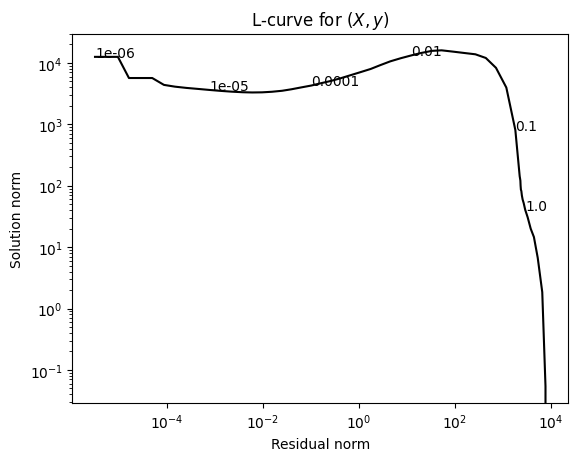

In [10]:
util.l_curve(-9,6,X_smogn,post_imp[:len(X_smogn)],100)